In [ ]:
%reset -f

import sys
sys.path.append('../code')

import numpy as np
import pandas as pd
import h5py
import matplotlib.pyplot as plt
import matplotlib
from fractions import Fraction
from hampel import hampel
from scipy import signal
import utility

from scipy.spatial.transform import Rotation as R

import pynumdiff
simulate = pynumdiff.utils.simulate
evaluate = pynumdiff.utils.evaluate

plt.rcParams['font.serif'] = ['Times'] + plt.rcParams['font.serif']
plt.rcParams['text.usetex'] = False
plt.rcParams["ps.usedistiller"] = 'xpdf'
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.weight'] = 'normal'

%matplotlib inline

from filemanager import FileManager 
from plot_utility import mathify_ticklabels
import direct_trajectory_simulator


## Load data

In [2]:
# Load data
# fpath = r'C:\Users\bcellini\OneDrive - University of Nevada, Reno\Research\Code\bag\data\mat\hdf5\NEW_2022-07-27-22-07-46.hdf'
# test = pd.read_hdf(fpath)

root = r'C:\Users\bcellini\OneDrive - University of Nevada, Reno\Research\Code\bag\data\mat\hdf5'

FileSelect = FileManager() # create FileManager instance
FileSelect.Select(root) # open file selection GUI in root folder

f = h5py.File(FileSelect.files[0], 'r')

In [3]:
# Get the data
intrp = f['intrp'] # work with interpolated data
raw = f['raw'] # work with raw data
keys = list(raw.keys())
print(keys)
# list(data['imu'])

['agf', 'att', 'avf', 'gps', 'gps_sync', 'imu', 'obtrs', 'opt', 'rc', 'rtk_pos', 'rtk_vel', 'rtk_yaw', 'utc_sync', 'vel', 'vo']


## Process data

In [118]:
# Interpolated time
time = np.swapaxes(np.array(intrp['time']), 0, 1)
dt = np.mean(np.diff(time, n=1, axis=0))
fs = 1 / dt

# GPS position
gps = intrp['gps']
gps_x = np.swapaxes(np.array(gps['x']), 0, 1)
gps_y = np.swapaxes(np.array(gps['y']), 0, 1)
gps_z = np.swapaxes(np.array(gps['z']), 0, 1)

# RTK GPS position
rtk_pos = intrp['rtk_pos']
rtk_x = np.swapaxes(np.array(rtk_pos['x']), 0, 1)
rtk_y = np.swapaxes(np.array(rtk_pos['y']), 0, 1)
rtk_z = np.swapaxes(np.array(rtk_pos['z']), 0, 1)

# IMU orientation
imu = intrp['imu']
# print(imu.keys())
imu_yaw_unwrap = np.swapaxes(np.array(imu['yaw_unwrap']), 0, 1)

b, a = signal.butter(5, 0.5 / (fs/2))
imu_yaw_filt = signal.filtfilt(b, a, np.squeeze(imu_yaw_unwrap))
imu_yaw_filt = np.swapaxes(np.array(imu_yaw_filt, ndmin=2), 0, 1)

imu_yaw = imu_yaw_unwrap % (2*np.pi)
imu_yaw_filt = imu_yaw_filt % (2*np.pi)

# GPS Velocty
vel = intrp['vel']
# print(vel.keys())
vel_x = np.swapaxes(np.array(vel['x']), 0, 1)
vel_y = np.swapaxes(np.array(vel['y']), 0, 1)
vel_z = np.swapaxes(np.array(vel['z']), 0, 1)

b, a = signal.butter(5, 0.1 / (fs/2))
vel_x_filt = signal.filtfilt(b, a, np.squeeze(vel_x))
vel_y_filt = signal.filtfilt(b, a, np.squeeze(vel_y))
vel_x_filt = np.swapaxes(np.array(vel_x_filt, ndmin=2), 0, 1)
vel_y_filt = np.swapaxes(np.array(vel_y_filt, ndmin=2), 0, 1)

vel_mag, vel_dir = utility.cart2polar(vel_x_filt, vel_y_filt)
vel_dir_body_frame = vel_dir - imu_yaw
vel_dir_body_frame = vel_dir_body_frame % (2*np.pi)

# Optic flow velocity
opt = intrp['opt']
print(opt.keys())
opt_x = np.swapaxes(np.array(opt['vxmean']), 0, 1)
opt_y = -np.swapaxes(np.array(opt['vymean']), 0, 1)

# opt_x_filt, dxdt_hat = pynumdiff.total_variation_regularization.jerk(np.squeeze(opt_x), dt, 100)
# opt_y_filt, dxdt_hat = pynumdiff.total_variation_regularization.jerk(np.squeeze(opt_y), dt, 100)

b, a = signal.butter(5, 0.1 / (fs/2))
opt_x_filt = signal.filtfilt(b, a, np.squeeze(opt_x))
opt_y_filt = signal.filtfilt(b, a, np.squeeze(opt_y))
opt_mag, opt_dir = utility.cart2polar(opt_x_filt, opt_y_filt)
opt_dir = opt_dir + (np.pi/2)
opt_dir = opt_dir % (2*np.pi)

opt_mag = np.swapaxes(np.array(opt_mag, ndmin=2), 0, 1)
opt_dir = np.swapaxes(np.array(opt_dir, ndmin=2), 0, 1)
# opt_dir = utility.wrapToPi(opt_dir)

# Onboard trisonica wind sensor
obtrs = intrp['obtrs']
# print(obtrs.keys())
air_speed_dir = np.swapaxes(np.array(obtrs['dir_unwrap']), 0, 1)

b, a = signal.butter(5, 0.2 / (fs/2))
air_speed_dir_filt = signal.filtfilt(b, a, np.squeeze(air_speed_dir))
air_speed_dir_filt = np.swapaxes(np.array(air_speed_dir_filt, ndmin=2), 0, 1)

air_speed_dir = utility.wrapTo2Pi(air_speed_dir)
air_speed_dir_filt = utility.wrapTo2Pi(air_speed_dir_filt)

air_speed_mag = np.squeeze(np.swapaxes(np.array(obtrs['speed']), 0, 1))
air_speed_mag = np.swapaxes(np.array( hampel(pd.Series(air_speed_mag), window_size=5, n=3, imputation=True), ndmin=2), 0, 1)

air_speed_mag2 = np.squeeze(np.swapaxes(np.array(obtrs['speed2']), 0, 1))
air_speed_mag2 = np.swapaxes(np.array(hampel(pd.Series(air_speed_mag2), window_size=5, n=3, imputation=True), ndmin=2), 0, 1)

b, a = signal.butter(5, 0.2 / (fs/2))
air_speed_mag_filt = signal.filtfilt(b, a, np.squeeze(air_speed_mag))
air_speed_mag_filt = np.swapaxes(np.array(air_speed_mag_filt, ndmin=2), 0, 1)

air_speed_mag2_filt = signal.filtfilt(b, a, np.squeeze(air_speed_mag2))
air_speed_mag2_filt = np.swapaxes(np.array(air_speed_mag2_filt, ndmin=2), 0, 1)

# air_speed_x = np.squeeze(np.swapaxes(np.array(obtrs['westeast']), 0, 1))
# air_speed_x = hampel(pd.Series(air_speed_x), window_size=5, n=3, imputation=True)

# air_speed_y = np.squeeze(np.swapaxes(np.array(obtrs['northsouth']), 0, 1))
# air_speed_y = hampel(pd.Series(air_speed_y), window_size=5, n=3, imputation=True)

# air_speed_z = np.squeeze(np.swapaxes(np.array(obtrs['updown']), 0, 1))
# air_speed_z = hampel(pd.Series(air_speed_z), window_size=5, n=3, imputation=True)

# r, theta = utility.cart2polar(air_speed_x, air_speed_y)


<KeysViewHDF5 ['vxmean', 'vymean']>


## Store processed data in new dataframe

In [119]:
# Concatenate data
alldata = np.concatenate((time, 1000*gps_x, 1000*gps_y, imu_yaw, imu_yaw_filt, opt_dir, air_speed_dir, air_speed_dir_filt, 
                          vel_mag, air_speed_mag2, air_speed_mag2_filt), axis=1)

names = ['t', 'xpos', 'ypos', 'phi', 'phi_filt', 'psi', 'gamma', 'gamma_filt',
         'g', 'a', 'a_filt']
   
# Create dataframe
df = pd.DataFrame(data = alldata, 
                  columns = names)
# print(df)

## Plot

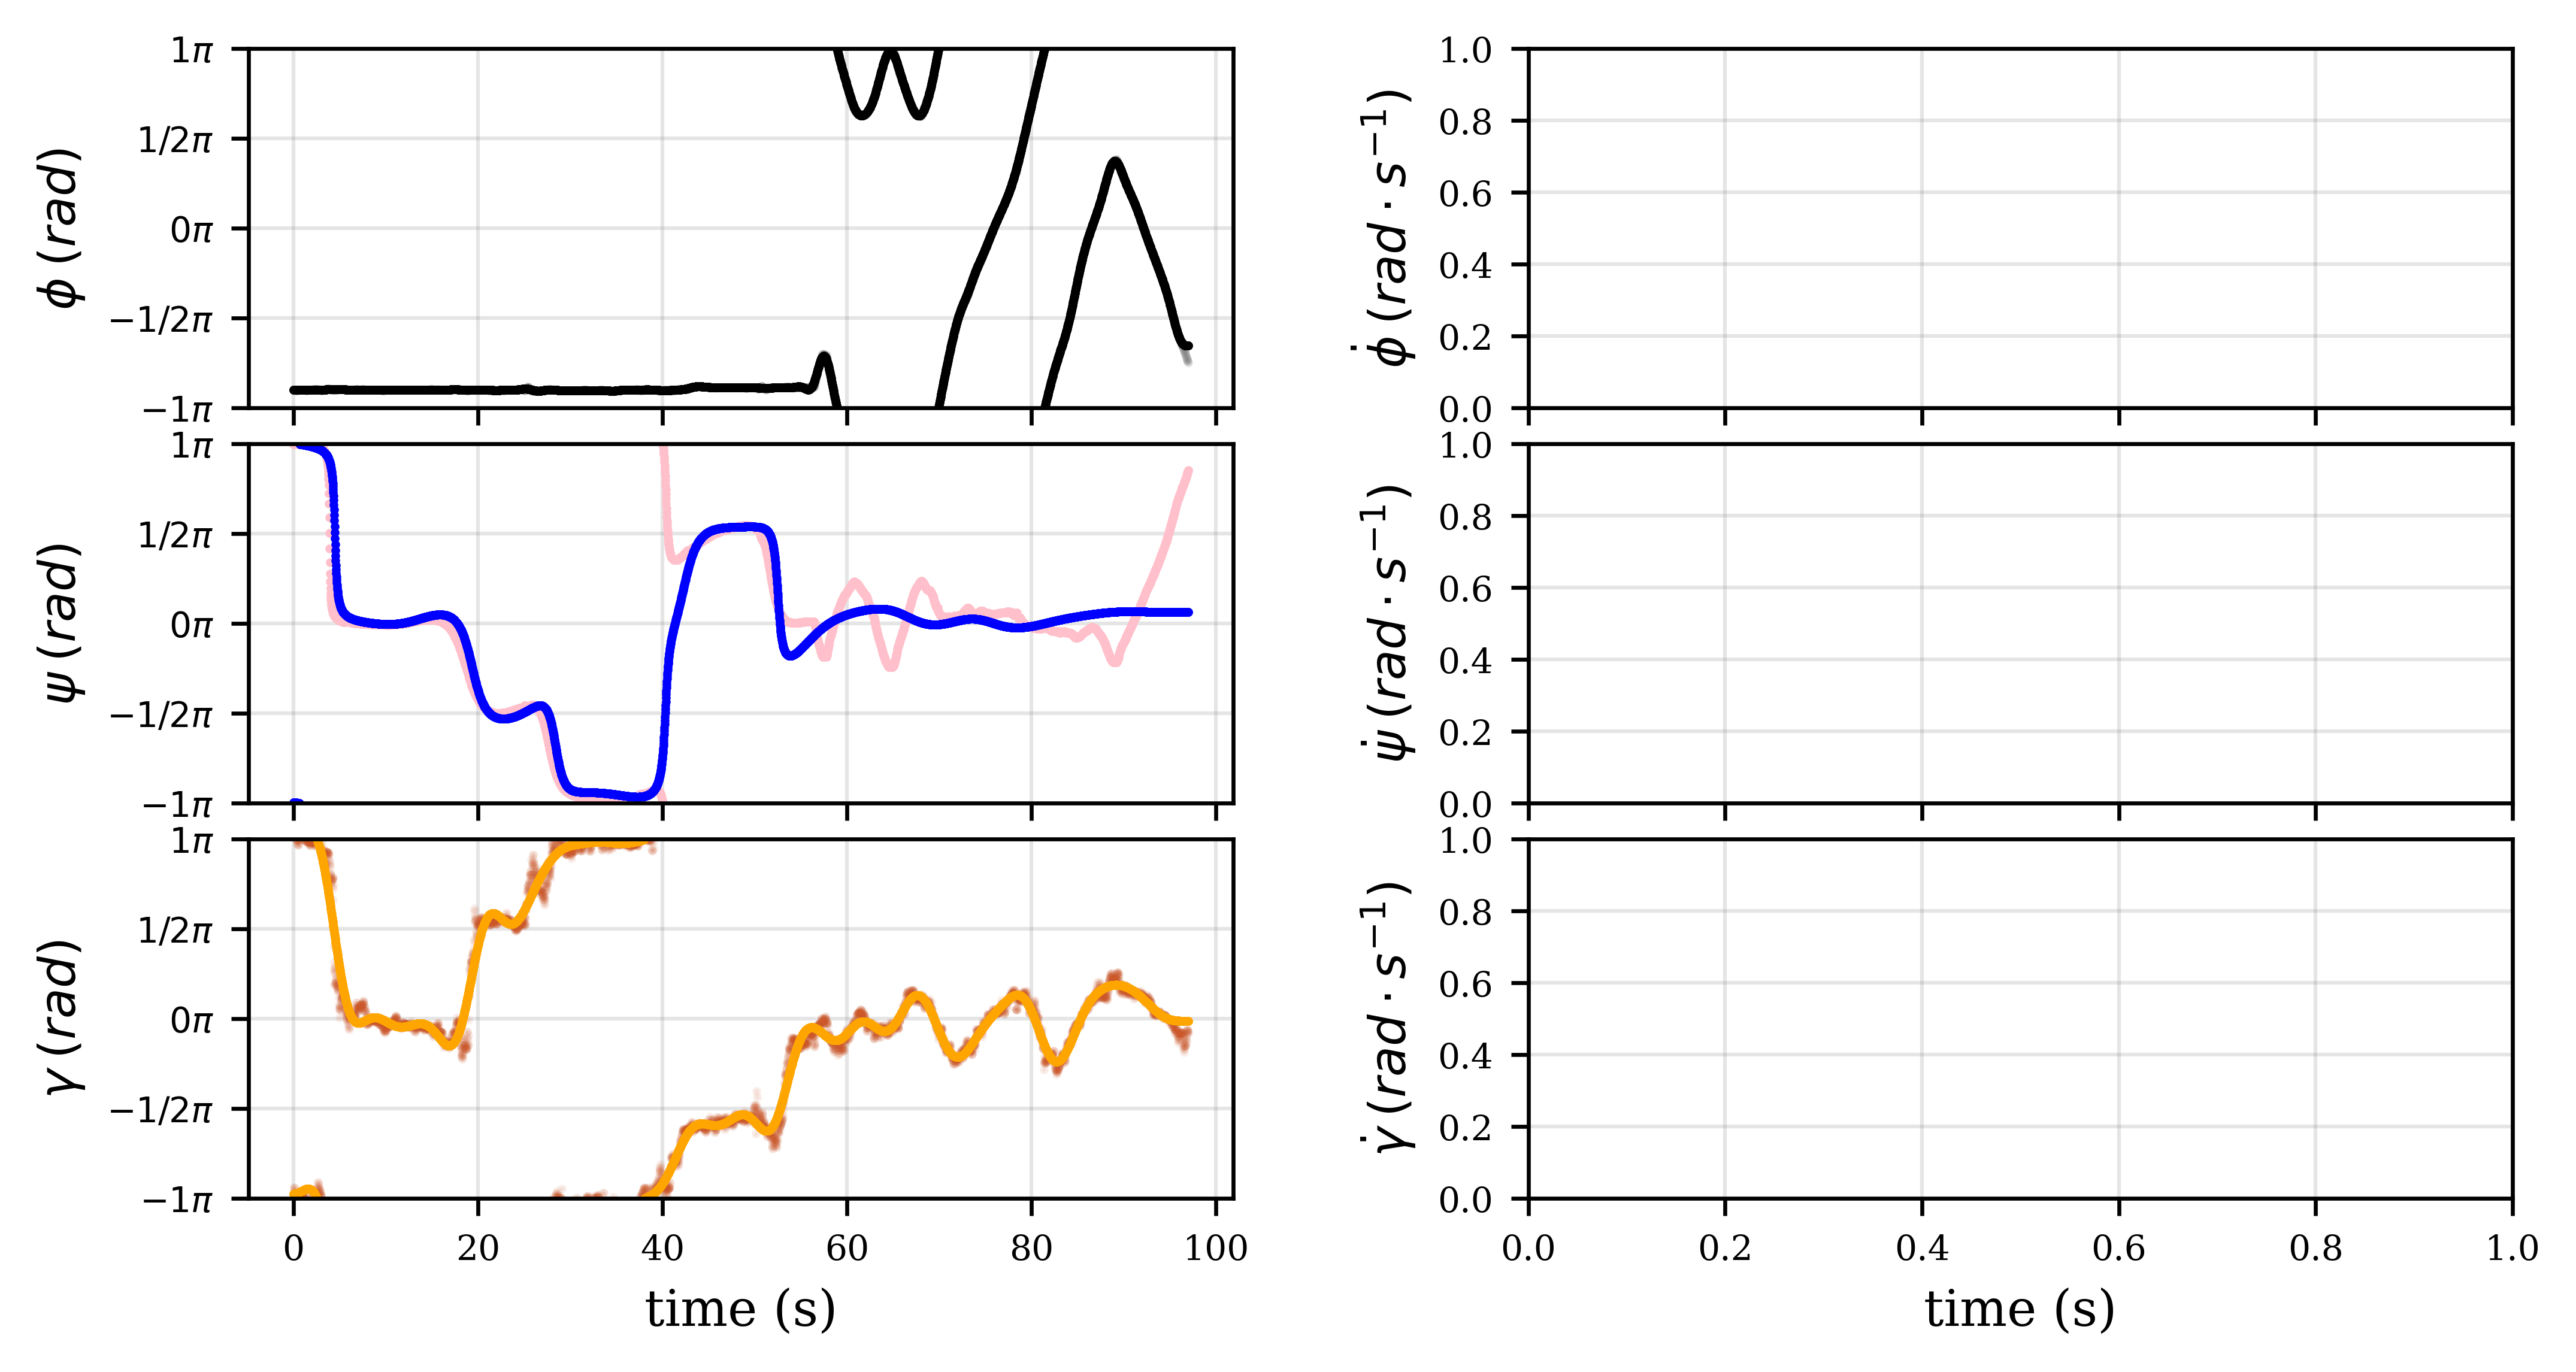

In [120]:
fig, ax = plt.subplots(3, 2, figsize=(7,4), dpi=600)
mksz = 1.5;

# Phi
ax[0,0].plot(time, utility.wrapToPi(df['phi']), color='gray',
             linestyle='',
             linewidth=1,
             marker = '.',
             markersize=mksz,
             alpha = 0.1)

ax[0,0].plot(time, utility.wrapToPi(df['phi_filt']), color='black',
             linestyle='',
             linewidth=1,
             marker = '.',
             markersize=mksz,
             alpha = 1)

# Psi
ax[1,0].plot(time, utility.wrapToPi(vel_dir_body_frame), color='pink',
             linestyle='',
             linewidth=1,
             marker = '.',
             markersize=mksz)
ax[1,0].plot(time, utility.wrapToPi(opt_dir), color='blue',
             linestyle='',
             linewidth=1,
             marker = '.',
             markersize=mksz)

# Gamma
ax[2,0].plot(time, utility.wrapToPi(df['gamma']), color=(0.80, 0.3451, 0.1647),
             linestyle='',
             linewidth=1,
             marker = '.',
             markersize=mksz,
             alpha = 0.1)

ax[2,0].plot(time, utility.wrapToPi(df['gamma_filt']), color='orange',
             linestyle='',
             linewidth=1,
             marker = '.',
             markersize=mksz)


# Plot formatting
ylabels = ['$\phi \:(rad)$', '$\dot{\phi} \:(rad \cdot s^{-1})$',
           '$\psi \:(rad)$', '$\dot{\psi} \:(rad \cdot s^{-1})$',
           '$\gamma \:(rad)$', '$\dot{\gamma} \:(rad \cdot s^{-1})$',
           r'$a \:(m \cdot s^{-1})$', '$\dot{a} \:(m \cdot s^{-2})$']

ytickpispace = 0.5
p = 1
for a in ax.reshape(-1):
    a.tick_params(axis='x', labelsize=7)
    a.tick_params(axis='y', labelsize=7)
    a.grid(color='gray', linestyle='-', linewidth=0.75, alpha=0.2)
    
    if p < 5:
        a.tick_params(axis='x', labelbottom=[])
    
    a.set_ylabel(ylabels[p-1])
    if p > 4:
        a.set_xlabel('time (s)')
        
    if (np.round(p/2) != (p/2)) and (p < 7):
        a.set_ylim(-1*np.pi, 1*np.pi)
        ylim = a.get_ylim()
        yticks = np.arange(ylim[0], ylim[1]+0.01, ytickpispace*np.pi)
        ytickpi = yticks / np.pi
        # ytickpi = np.array([0, 1/2, 1, 3/2, 2])
        # yticks = np.pi * ytickpi
        ytickslabels = ytickpi.tolist()
        for y in range(len(ytickslabels)):
            ytickslabels[y] = ('$'+ str(Fraction(ytickslabels[y])) + '\pi$')
        
        a.set_yticks(yticks)
        a.set_yticklabels(ytickslabels)
        
    p = p + 1
    
left  = 0.0  # the left side of the subplots of the figure
right = 0.9    # the right side of the subplots of the figure
bottom = 0.1   # the bottom of the subplots of the figure
top = 0.9      # the top of the subplots of the figure
wspace = 0.3   # the amount of width reserved for blank space between subplots
hspace = 0.1   # the amount of height reserved for white space between subplots

plt.subplots_adjust(left=left, bottom=bottom, right=right, top=top, wspace=wspace, hspace=hspace)

plt.show()


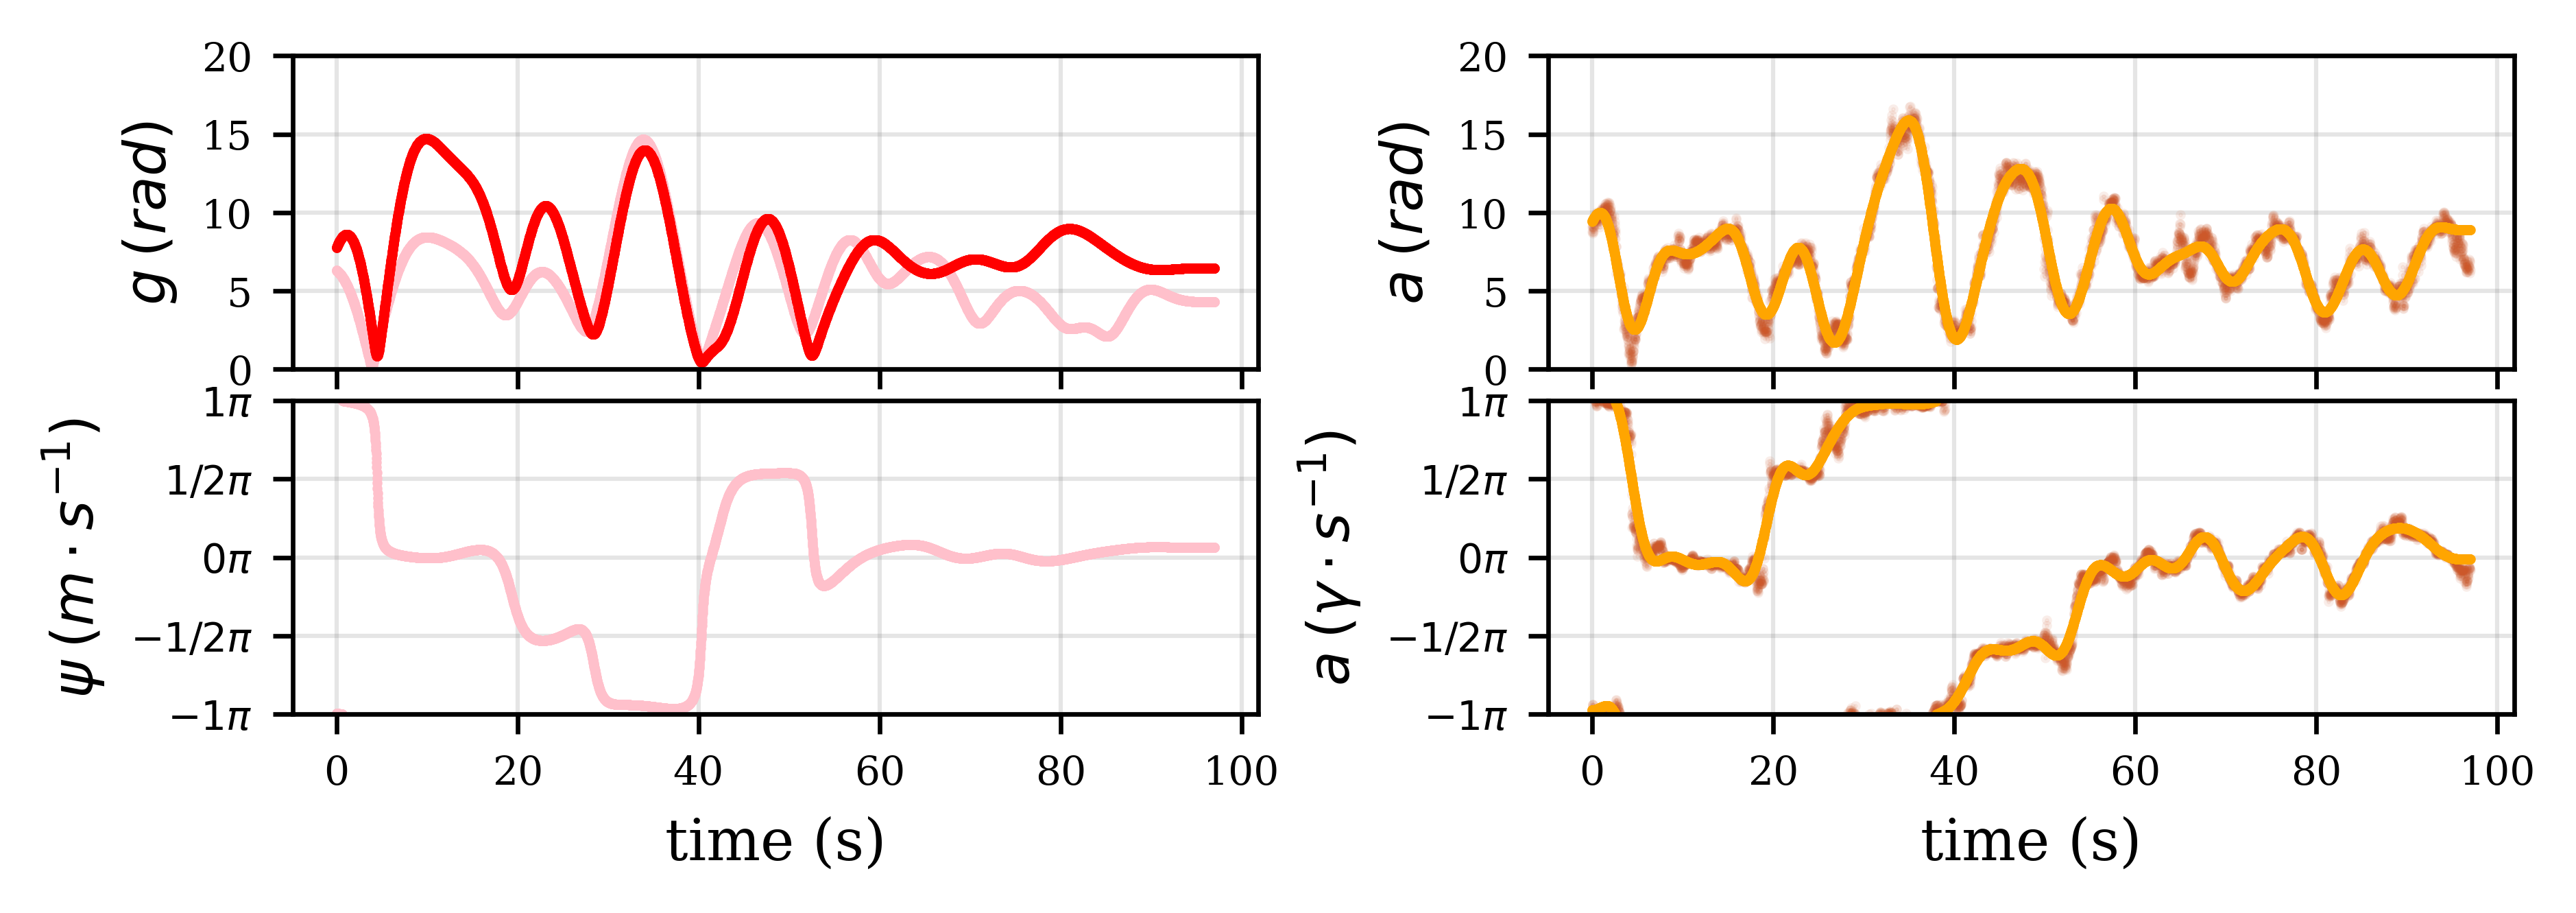

In [137]:
fig, ax = plt.subplots(2, 2, figsize=(6,2), dpi=600)

# g
ax[0,0].plot(time, df['g'], color='pink',
             linestyle='',
             linewidth=1,
             marker='.',
             markersize=mksz,
             alpha=1)
ax[0,0].plot(time, 1.6*opt_mag, color='red',
             linestyle='',
             linewidth=1,
             marker='.',
             markersize=mksz,
             alpha=1)

# Psi
ax[1,0].plot(time, utility.wrapToPi(df['psi']), color='pink',
             linestyle='',
             linewidth=1,
             marker='.',
             markersize=mksz,
             alpha=1)


# a
ax[0,1].plot(time, df['a'], color=(0.80, 0.3451, 0.1647),
             linestyle='',
             linewidth=1,
             marker = '.',
             markersize=mksz,
             alpha=0.1)

ax[0,1].plot(time, df['a_filt'], color='orange',
             linestyle='',
             linewidth=1,
             marker='.',
             markersize=mksz,
             alpha=1)

# Gamma
ax[1,1].plot(time, utility.wrapToPi(df['gamma']), color=(0.80, 0.3451, 0.1647),
             linestyle='',
             linewidth=1,
             marker = '.',
             markersize=mksz,
             alpha = 0.1)

ax[1,1].plot(time, utility.wrapToPi(df['gamma_filt']), color='orange',
             linestyle='',
             linewidth=1,
             marker = '.',
             markersize=mksz)


ylabels = ['$g \:(rad)$', '$a \:(rad)$', r'$\psi \:(m \cdot s^{-1})$', r'$a \:(\gamma \cdot s^{-1})$']

ytickpispace = 0.5
p = 1
for a in ax.reshape(-1):
    a.tick_params(axis='x', labelsize=7)
    a.tick_params(axis='y', labelsize=7)
    a.grid(color='gray', linestyle='-', linewidth=0.75, alpha=0.2)
    
    if p < 3:
        a.tick_params(axis='x', labelbottom=[])
    
    a.set_ylabel(ylabels[p-1])
    if p > 2:
        a.set_xlabel('time (s)')
        
    if p > 2:
        a.set_ylim(-1*np.pi, 1*np.pi)
        ylim = a.get_ylim()
        yticks = np.arange(ylim[0], ylim[1]+0.01, ytickpispace*np.pi)
        ytickpi = yticks / np.pi
        ytickslabels = ytickpi.tolist()
        for y in range(len(ytickslabels)):
            ytickslabels[y] = ('$'+ str(Fraction(ytickslabels[y])) + '\pi$')
        a.set_yticks(yticks)
        a.set_yticklabels(ytickslabels)
    else:
        a.set_yticks(np.arange(0,50,5))
        a.set_ylim(0, 20)
        
    p = p + 1
    
left  = 0.0  # the left side of the subplots of the figure
right = 0.9    # the right side of the subplots of the figure
bottom = 0.1   # the bottom of the subplots of the figure
top = 0.9      # the top of the subplots of the figure
wspace = 0.3   # the amount of width reserved for blank space between subplots
hspace = 0.1   # the amount of height reserved for white space between subplots

plt.subplots_adjust(left=left, bottom=bottom, right=right, top=top, wspace=wspace, hspace=hspace)


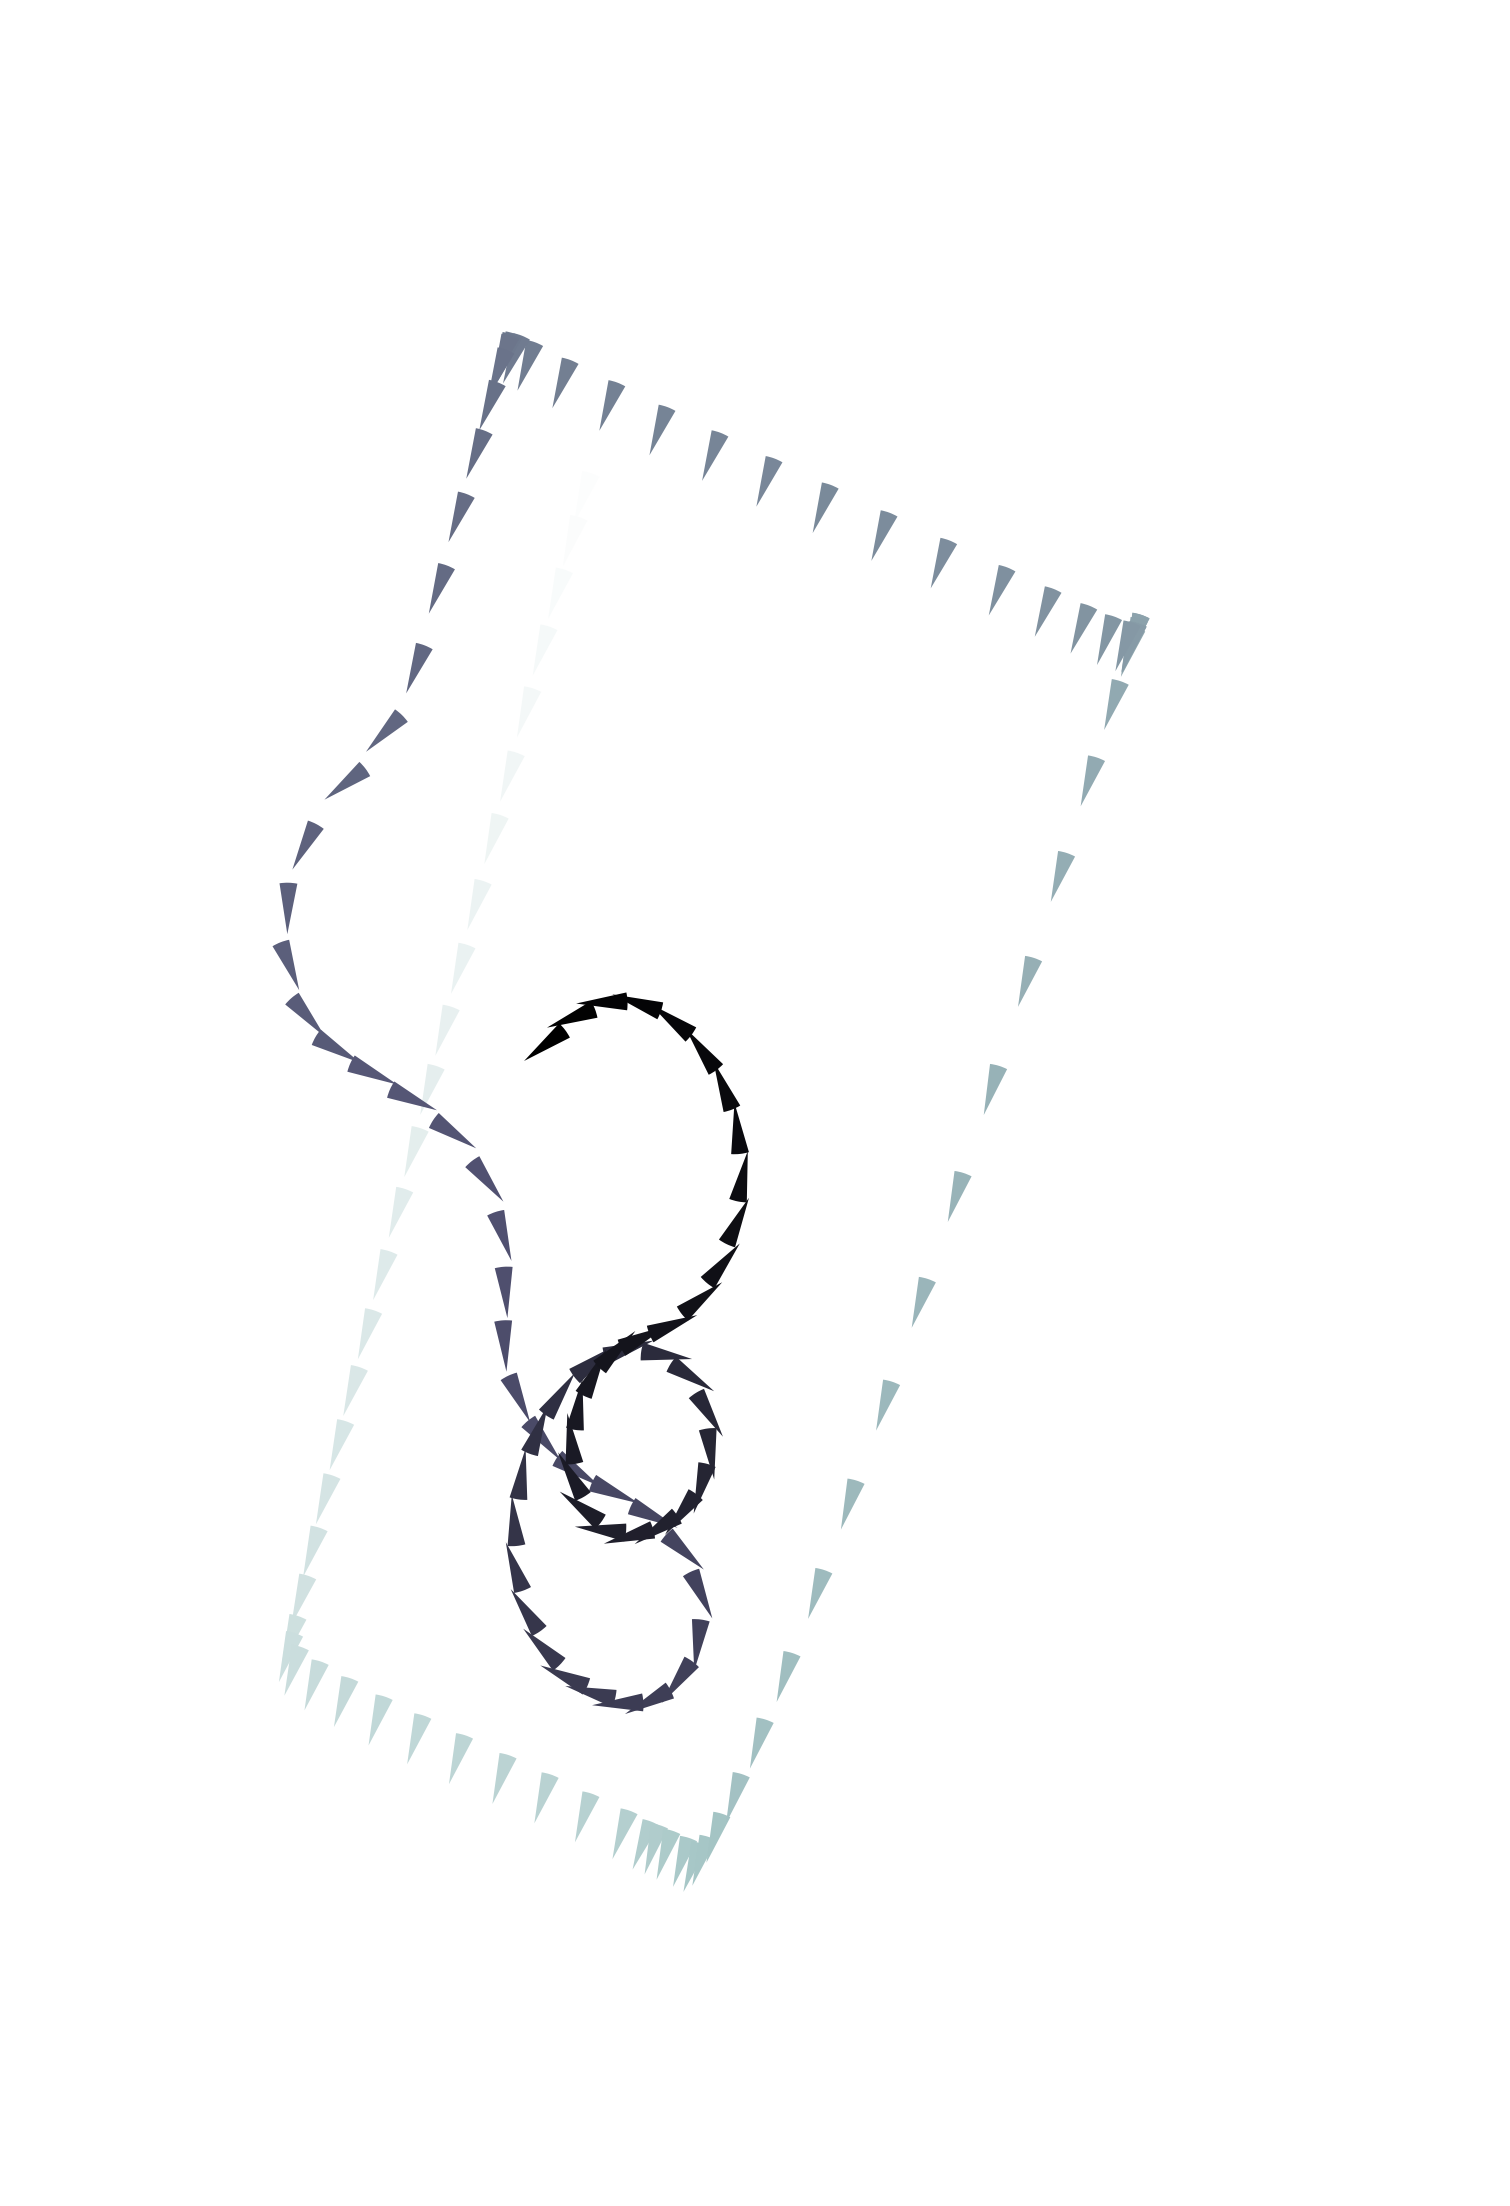

In [88]:
plotdata = df.copy()
plotdata['phi'] = -plotdata['phi'].values + np.deg2rad(90)
size_radius = 0.15*np.mean(np.abs(np.hstack((df['xpos'] , df['ypos']))))

fig = plt.figure(figsize=(4,4), dpi=600)
ax = fig.add_subplot(111)
utility.plot_trajec(plotdata, ax=ax,
                    size_radius=size_radius,
                    nskip=30,
                    show_wind_quivers=False,
                    colormap='bone_r')
plt.show()

RMS error in velocity:  6.820305856536254


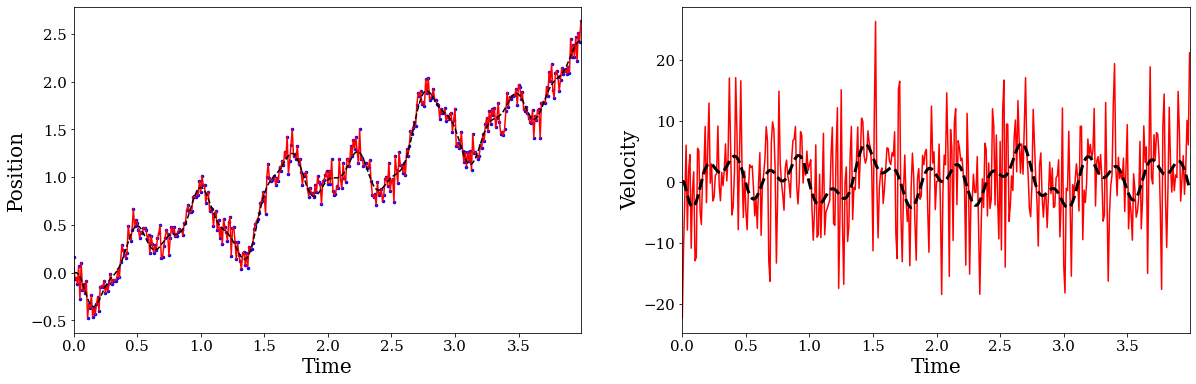

In [79]:
noise_type = 'normal'
noise_parameters = [0, 0.1]  # mean and std

# time step size and time series length in TIME
dt = 0.01
timeseries_length = 4
# simulate data

x, x_truth, dxdt_truth, _ = simulate.pi_control(dt=dt, timeseries_length=timeseries_length, 
                                                noise_type=noise_type, noise_parameters=noise_parameters)

fc = 1;
log_gamma = -1.6*np.log(fc) -0.71*np.log(dt) - 5.1 # see: https://ieeexplore.ieee.org/abstract/document/9241009
tvgamma = np.exp(log_gamma) 
      
x_hat, dxdt_hat = pynumdiff.finite_difference.first_order(x, dt)
# params, val = pynumdiff.optimize.sub_module.method(x, dt, params=None, 
#                                                    tvgamma=tvgamma, # hyperparameter
#                                                    dxdt_truth=None, # no ground truth data
#                                                    options={})

# params = [10]
# print('Optimal parameters: ', params)
# x_hat, dxdt_hat = pynumdiff.sub_module.method(x, dt, params, options={'smooth': True})

evaluate.plot(x, dt, x_hat, dxdt_hat, x_truth, dxdt_truth)